In [2]:
# 1. Importando as bilbiotecas de interesse
from fenics import *
import numpy as np
import os
import shutil
import time
import matplotlib.pyplot as plt

# 1.1. Importando as propriedades
from propriedades_5CAC import *
from utils import *
print(f'| Bibliotecas importadas com sucesso!')
print('----------------------------------------')
# 2. Definição do nome do caso
case_name = 'real_case_01'
print(f'| Rodando o caso: "{case_name}"...')


# 3. Criação da pasta de resultados do caso
dir_saida, dir_local = criar_pasta(case_name)
print('|--- Pasta criada com sucesso!')

# 4. Criação dos backups
# 4.1. Backup da Simulação
shutil.copy(dir_local + '/Fake Simulation.ipynb',
            dir_saida + '/backup_' + case_name + '.ipynb')
# 4.2. Backup das Propriedades
shutil.copy(dir_local + '/propriedades_5CAC.py',
            dir_saida + '/backup_propriedades.py')
print('|--- Back-up criado com sucesso!')

# 5. Criação da malha
def criar_malha(lx, ly, nx, ny):
    '''

    '''
    
    malha = RectangleMesh(Point(0, 0), Point(lx, ly), nx, ny)
    
    flags = MeshFunction('size_t', malha, malha.topology().dim() - 1)
    flags.set_all(0)

    class top(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], ly, 1e-2)


    class bottom(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0, 1e-2)

 
    class left(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, 1e-2)


    class right(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], lx, 1e-2)

    top = top()
    bottom = bottom()
    left = left()
    right = right()
    
    top.mark(flags, 1)
    bottom.mark(flags, 2)
    left.mark(flags, 3)
    right.mark(flags, 4)

    print('|--- Malha criada com sucesso!')
    return malha, flags

lx = 1
ly = 3
nx = 10
ny = 30
malha, flags = criar_malha(lx, ly, nx, ny)

| Bibliotecas importadas com sucesso!
----------------------------------------
| Rodando o caso: "real_case_01"...
|--- Pasta criada com sucesso!
|--- Back-up criado com sucesso!
|--- Malha criada com sucesso!


# Alternativas para visualizar flags

## Método 1 - Usando Paraview

In [181]:
# Salvando a MeshFunction flags em um arquivo .pvd que pode ser aberto pelo Paraview
File('flags.pvd') << flags

## Método 2 - Iterando sobre as ``facets``

Cada malha no FEniCS é composta por diferentes "entities":
- Vertices
- Edges
- Facets
- Cells

<center>Colinha:</center>

|FEniCS|   1D  |   2D   | 3D     |
|----- | ----- | -----  | ------ |
|vertex| nó    |   nó   | nó     |
|edges | linha |  linha | linha  |
|facet | nó    |  linha | área   |
| cell | linha |  área  | volume |


In [182]:
# Função para obter o número de vertices, edges, facets e cells de uma malha
def get_vefc_len(mesh):
    mesh_vertices = [edge for edge in vertices(mesh)]
    mesh_edges = [edge for edge in edges(mesh)]
    mesh_facets = [edge for edge in facets(mesh)]
    mesh_cells = [edge for edge in cells(mesh)]

    return len(mesh_vertices), len(mesh_edges), len(mesh_facets), len(mesh_cells)

In [183]:
# Criando malhas de diferentes dimensões topológicas
mesh_1D = UnitIntervalMesh(9)
mesh_2D = UnitSquareMesh(9, 9)
mesh_3D = UnitCubeMesh(9, 9, 9)

# Obtendo os números das entidades 
vefc_len_1D = get_vefc_len(mesh_1D)
vefc_len_2D = get_vefc_len(mesh_2D)
vefc_len_3D = get_vefc_len(mesh_3D)

print(f'N_vértices (nós) = {vefc_len_1D[0]} | N_edges = {vefc_len_1D[1]} | N_facets = {vefc_len_1D[2]} | N_células (elementos) = {vefc_len_1D[3]}')
print(f'N_vértices (nós) = {vefc_len_2D[0]} | N_edges = {vefc_len_2D[1]} | N_facets = {vefc_len_2D[2]} | N_células (elementos) = {vefc_len_2D[3]}')
print(f'N_vértices (nós) = {vefc_len_3D[0]} | N_edges = {vefc_len_3D[1]} | N_facets = {vefc_len_3D[2]} | N_células (elementos) = {vefc_len_3D[3]}')

N_vértices (nós) = 10 | N_edges = 9 | N_facets = 10 | N_células (elementos) = 9
N_vértices (nós) = 100 | N_edges = 261 | N_facets = 261 | N_células (elementos) = 162
N_vértices (nós) = 1000 | N_edges = 5859 | N_facets = 9234 | N_células (elementos) = 4374


In [4]:
# List Comprehension
arestas_flag_1_LC = [facet for facet in facets(malha) if flags[facet] == 1]

# For loop
arestas_flag_1_FL = []
for facet in facets(malha):
    if flags[facet] == 1:
        arestas_flag_1_FL.append(facet)        


In [184]:
# Pegando a lista de facets (arestas) que estão marcadas com determinada flag
arestas_flag_1 = [facet for facet in facets(malha) if flags[facet] == 1]
arestas_flag_2 = [facet for facet in facets(malha) if flags[facet] == 2]
arestas_flag_3 = [facet for facet in facets(malha) if flags[facet] == 3]
arestas_flag_4 = [facet for facet in facets(malha) if flags[facet] == 4]

# Iterando sobre as arestas marcadas com flag 1 para encontrar os vértices destas arestas
nós_arestas_flag_1 = []
for facet in arestas_flag_1:
    vertex_indices = facet.entities(0)  # Pegando os indices das entidades de dimensão topológica 0 do facet (isto é, os nós/vértices)
    for vertex_index in vertex_indices:  # Iterando sobre os índices globais vértices da facet (aresta)
        vertex = Vertex(malha, vertex_index)  # Obtendo o vértice que tem tal índice global
        nós_arestas_flag_1.append(vertex.point().array()[:2])  # Salvando na lista
        
# Iterando sobre as arestas marcadas com flag 2 para encontrar os vértices destas arestas
nós_arestas_flag_2 = []
for facet in arestas_flag_2:
    vertex_indices = facet.entities(0)  # Pegando os indices das entidades de dimensão topológica 0 do facet (isto é, os nós/vértices)
    for vertex_index in vertex_indices:  # Iterando sobre os índices globais vértices da facet (aresta)
        vertex = Vertex(malha, vertex_index)  # Obtendo o vértice que tem tal índice global
        nós_arestas_flag_2.append(vertex.point().array()[:2])  # Salvando na lista
        
# Iterando sobre as arestas marcadas com flag 3 para encontrar os vértices destas arestas
nós_arestas_flag_3 = []
for facet in arestas_flag_3:
    vertex_indices = facet.entities(0)  # Pegando os indices das entidades de dimensão topológica 0 do facet (isto é, os nós/vértices)
    for vertex_index in vertex_indices:  # Iterando sobre os índices globais vértices da facet (aresta)
        vertex = Vertex(malha, vertex_index)  # Obtendo o vértice que tem tal índice global
        nós_arestas_flag_3.append(vertex.point().array()[:2])  # Salvando na lista
        
# Iterando sobre as arestas marcadas com flag 4 para encontrar os vértices que correspondem a qual flag
nós_arestas_flag_4 = []
for facet in arestas_flag_4:
    vertex_indices = facet.entities(0)  # Pegando os indices das entidades de dimensão topológica 0 do facet (isto é, os nós/vértices)
    for vertex_index in vertex_indices:  # Iterando sobre os índices globais vértices da facet (aresta)
        vertex = Vertex(malha, vertex_index)  # Obtendo o vértice que tem tal índice global
        nós_arestas_flag_4.append(vertex.point().array()[:2])  # Salvando na lista
        
        
# Transformando em numpy arrays
nós_arestas_flag_1 = np.array(nós_arestas_flag_1)
nós_arestas_flag_2 = np.array(nós_arestas_flag_2)
nós_arestas_flag_3 = np.array(nós_arestas_flag_3)
nós_arestas_flag_4 = np.array(nós_arestas_flag_4)



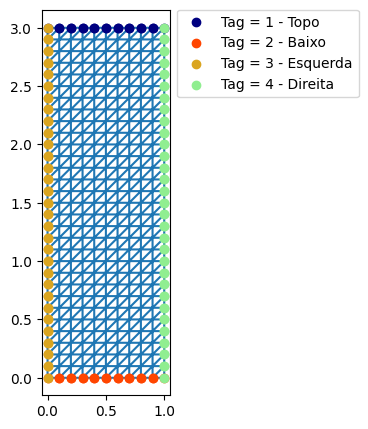

In [185]:
fig = plt.figure(figsize=(2.5, 5), dpi=100)
plt.gca().set_aspect('equal')
plt.triplot(malha_coord_x, malha_coord_y, malha.cells())


plt.scatter(nós_arestas_flag_1[:, 0], nós_arestas_flag_1[:, 1], c='navy', label='Tag = 1 - Topo')
plt.scatter(nós_arestas_flag_2[:, 0], nós_arestas_flag_2[:, 1], c='orangered', label='Tag = 2 - Baixo')
plt.scatter(nós_arestas_flag_3[:, 0], nós_arestas_flag_3[:, 1], c='goldenrod', label='Tag = 3 - Esquerda')
plt.scatter(nós_arestas_flag_4[:, 0], nós_arestas_flag_4[:, 1], c='lightgreen', label='Tag = 4 - Direita')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.show()



## Usando `entity_closure_dofs()`

In [188]:
# Para essa metodologia vamos precisar criar um espaço de funções sobre nossa malha
V = FunctionSpace(malha, 'CG', 1)

# Pegando os índices das arestas com flag 1
arestas_flag_1 = np.where(flags.array() == 1)[0]
dofs_arestas_flag_1 = V.dofmap().entity_closure_dofs(malha, 1, arestas_flag_1)
indíces_nós_arestas_flag_1 = dof_to_vertex_map(V)[dofs_arestas_flag_1]


# Pegando os índices das arestas com flag 1
arestas_flag_2 = np.where(flags.array() == 2)[0]
dofs_arestas_flag_2 = V.dofmap().entity_closure_dofs(malha, 1, arestas_flag_2)
indíces_nós_arestas_flag_2 = dof_to_vertex_map(V)[dofs_arestas_flag_2]

# Pegando os índices das arestas com flag 1
arestas_flag_3 = np.where(flags.array() == 3)[0]
dofs_arestas_flag_3 = V.dofmap().entity_closure_dofs(malha, 1, arestas_flag_3)
indíces_nós_arestas_flag_3 = dof_to_vertex_map(V)[dofs_arestas_flag_3]

# Pegando os índices das arestas com flag 4
arestas_flag_4 = np.where(flags.array() == 4)[0]
dofs_arestas_flag_4 = V.dofmap().entity_closure_dofs(malha, 1, arestas_flag_4)
indíces_nós_arestas_flag_4 = dof_to_vertex_map(V)[dofs_arestas_flag_4]

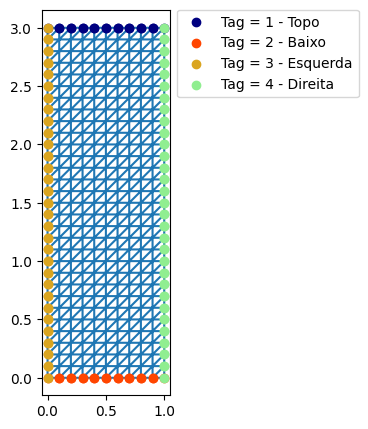

In [190]:
fig = plt.figure(figsize=(2.5, 5), dpi=100)
plt.gca().set_aspect('equal')
plt.triplot(malha_coord_x, malha_coord_y, malha.cells())


plt.scatter(malha_coord_x[indíces_nós_arestas_flag_1], malha_coord_y[indíces_nós_arestas_flag_1], c='navy', label='Tag = 1 - Topo')
plt.scatter(malha_coord_x[indíces_nós_arestas_flag_2], malha_coord_y[indíces_nós_arestas_flag_2], c='orangered', label='Tag = 2 - Baixo')
plt.scatter(malha_coord_x[indíces_nós_arestas_flag_3], malha_coord_y[indíces_nós_arestas_flag_3], c='goldenrod', label='Tag = 3 - Esquerda')
plt.scatter(malha_coord_x[indíces_nós_arestas_flag_4], malha_coord_y[indíces_nós_arestas_flag_4], c='lightgreen', label='Tag = 4 - Direita')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.show()
